In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator, interpolant
import torch
import torch.nn as nn
import torch.optim as optim
import time




In [2]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)


In [3]:
# Normalização de dados para o intervalo [-1, 1]
def normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = 2 * (Mat_dados[:, i] - min_value) / (max_value - min_value) - 1
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = 2 * (Mat_dados[:] - min_value) / (max_value - min_value) - 1

    return result





# Desnormalização de dados do intervalo [-1, 1] para os valores originais
def des_normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] + 1) * (max_value - min_value) / 2 + min_value


    return result





# Normalização de dados para as redes.
def zero_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
                max_value = Mat_ref[:,i].max()
                min_value = Mat_ref[:,i].min()
                result[:,i] = (Mat_dados[:,i] - min_value) / (max_value - min_value)
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] - min_value) / (max_value - min_value)

    return result
# Desnormalização de dados para as redes.
def zero_des_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:,i].max()
            min_value = Mat_ref[:,i].min()
            result[:,i] = (Mat_dados[:,i] ) * (max_value - min_value) + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] ) * (max_value - min_value) + min_value

    return result

In [4]:
import pandas as pd


def create_interpolation(file_path, decimal=','):

    # Carregar os dados do CSV
    data = pd.read_csv(file_path, decimal=decimal)
    
    # Configurar os eixos da malha
    N_rot = np.arange(2e4, 6e4, 1e3)  # De 20000 rpm a 60000 rpm, Shape: (40,)
    Mass = np.arange(3, 21.1, 0.1)   # De 3 a 21, Shape: (181,)
    Phi = data.values                # Valores da tabela, Shape: (40,181)
    
    # Linearizar a matriz Phi para criação da LUT
    phi_flat = Phi.ravel(order='F')
    
    # Criar a LUT usando interpolação b-spline
    lut = interpolant('name', 'bspline', [N_rot, Mass], phi_flat)
    
    return lut

# Caminho para o arquivo CSV
file_path = r"C:\Users\fabio\Downloads\tabela_phi.csv"

# Chamar a função e obter a LUT
interpolation = create_interpolation(file_path)

N_rot_example = 40412.61691244799
Mass_example = 9.62476391 
result = interpolation([N_rot_example, Mass_example]) 

# Exibir o resultado
print(f"Interpolação para N_rot={N_rot_example}, Mass={Mass_example}: {result}")

Interpolação para N_rot=40412.61691244799, Mass=9.62476391: 1.49599


In [5]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4500, 4800)  # KPa
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value



class N_generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def N(self):
        while True:
            value = np.random.uniform(4e4, 5e4)  #Hz   # 4e4, 5e4
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value
            



p1_gen = P1Generator(seed)
N_gen = N_generator(seed)

In [6]:
def Nale():
    return np.random.uniform(45e4, 50e3)
def P1():
    return np.random.uniform(4000, 5000)

In [7]:
def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3        # m²
    L_c = 2.0          # m
    alpha = 0.75    #  Constante de Abertura da Valvula
    P_out = 5000       # KPa
    C1 = 479.029       # Constante
    V_p = 2.0          # m³
    K_nu = 0.38 
    0 #0.0765      # kg / (kPa^0.5 s)
    phi = interpolation([45000, x[0]]).__float__() 

    z = 0 if x[1] < P_out else np.sqrt(x[1]   - P_out)

    dmdt = (A1 / L_c) * (phi * 5000 - x[1])*1000 
    dPdt = (C1**2/V_p) * (x[0] - alpha * K_nu * sqrt(x[1] - P_out))/1000
    return [dmdt, dPdt]

stati = fsolve(Estacionario, [10, 9e3])

print(stati,Estacionario(stati))

[  13.40272212 7211.54768046] [np.float64(-4.8814217734616246e-08), np.float64(-1.0347394145815488e-09)]


In [8]:
def Sistemas(x0, P1_value, interpolant_function, N_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p',2)
    start = time.time()

    #N = p[1]
    phi = interpolant_function(vertcat(p[1], x[0]))
    
    # Constantes
    A1 = 2.6e-3          # m²
    L_c = 2.0            # m
    alpha = 0.75        # Constante Abertura da valvula
    P_out = 5000         #  kPa
    C1 = 479.029         # Constante Velocidade do Som na Entrada do Compressor 
    V_p = 2.0            # m³
    K_nu = 0.38          # kg / (kPa^0.5 s)
    phi_value = 1.5      # 

    z = if_else(x[1] < P_out, 0, sqrt(x[1] - P_out))
    non = if_else(phi<0,phi+1,phi)
    
    rhs = vertcat(
        (A1 / L_c) * ( non* p[0] - x[1] )*1000,                                     # Vazão Massica/ dt
        (C1**2 / V_p) * (x[0] - alpha* K_nu * sqrt(x[1] - P_out))/1000                             # Pressão do Plenum / dt
    ) 

    ode = {'x': x, 'ode': rhs , 'p': p}
    
    F = integrator('F', 'cvodes', ode)

    #
    t_eval = np.linspace(0, 10,20)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9
    sol[0,:] = x0
    #
    print(P1_value, N_value)
    for i in range(len(t_eval)-1):
        param = [P1_value, N_value]
        res = F(x0=x0, p=param)
        x_next = res['xf'].full().flatten()
        sol[i+1] = x_next
        # Update initial state
        x0 = x_next

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    return sol, P1_value,N_value, t_eval
    


In [9]:
def Loop(loops, stati):
    estados = []
    p1_total = []
    N_total = []
    t_eval_total = []
    for i in range(loops):
        if i == 0:
            x0 = stati  # Estado inicial
        else:
            x0 = estados[-1][-1]
        print(x0)
        P1_v = p1_gen.P1()  # Geração aleatória de P1
        N_v = N_gen.N()
        sol, P1_aleatorio,aaaa, t_eval = Sistemas(x0, P1_v, interpolation, N_v)
        estados.append(sol)
        N_total.append(aaaa)
        p1_total.append(P1_aleatorio)
        
        # Concatenar tempo
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, N_total, t_total

[  13.40272212 7211.54768046]
4543.073705057584 46555.132857187054
Tempo de execução: 0.009643077850341797 segundos
[  13.12630217 7121.26760482]
4793.922119056667 48105.13889479911
Tempo de execução: 0.00382232666015625 segundos
[  14.15804523 7467.81119253]
4714.803146279291 47697.407491562015
Tempo de execução: 0.01677417755126953 segundos
[  13.87207124 7369.15790315]
4548.874763779707 44887.4801327325
Tempo de execução: 0.016322851181030273 segundos
[  12.53166824 6933.43214484]
4683.347251447797 41893.56507853562
Tempo de execução: 0.01195836067199707 segundos
[  11.7520025  6700.33456014]
4516.1910436306935 42615.52549469215
Tempo de execução: 0.0039234161376953125 segundos
[  11.64038605 6668.1883509 ]
4766.285294634397 40412.61691244799
Tempo de execução: 0.00911402702331543 segundos
[  11.4127906 6603.5927368]
4586.45478606353 40939.59361153285
Tempo de execução: 0.008049964904785156 segundos
[  11.20621245 6546.06599772]
4704.252585084683 42520.21989918103
Tempo de execução:

C:\Users\fabio\AppData\Local\Temp\ipykernel_25380\499536382.py:22: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

C:\Users\fabio\AppData\Local\Temp\ipykernel_25380\499536382.py:37: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



<Figure size 3000x100 with 0 Axes>

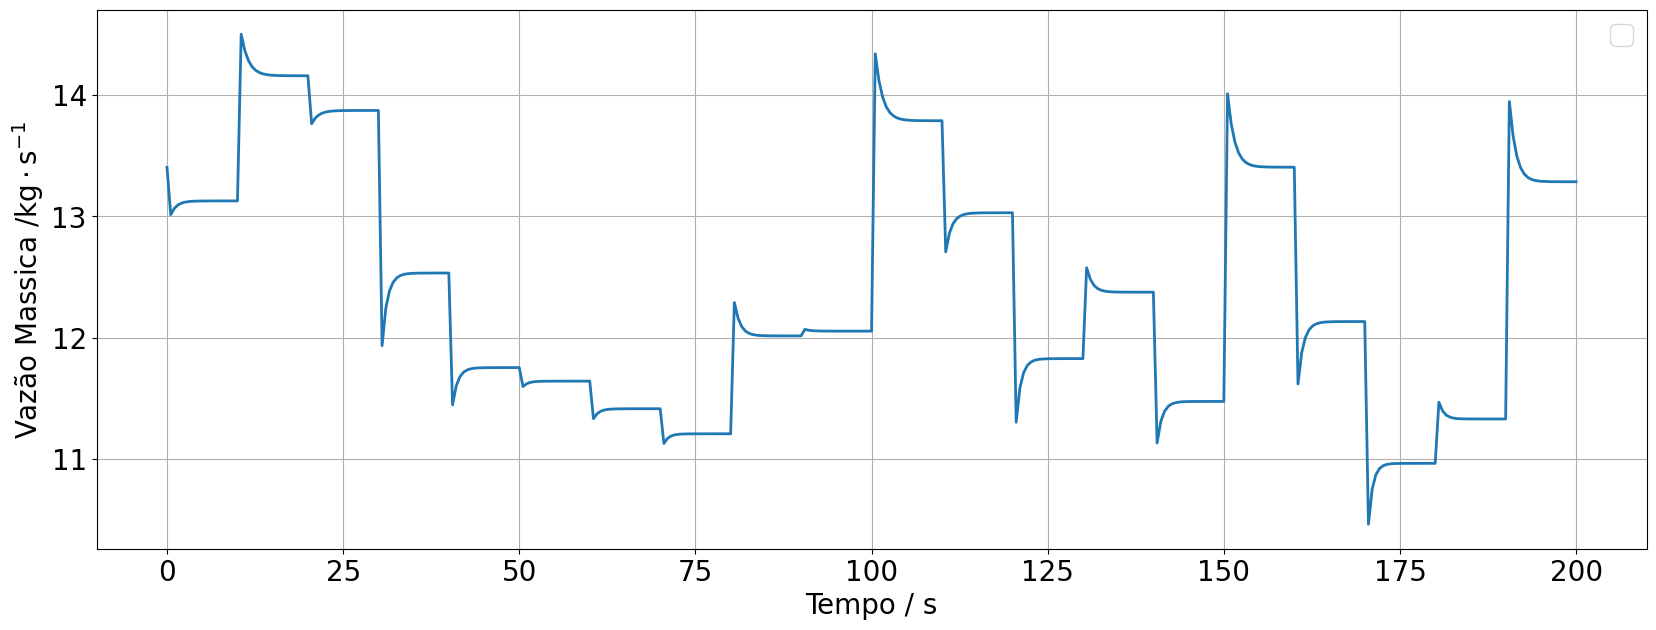

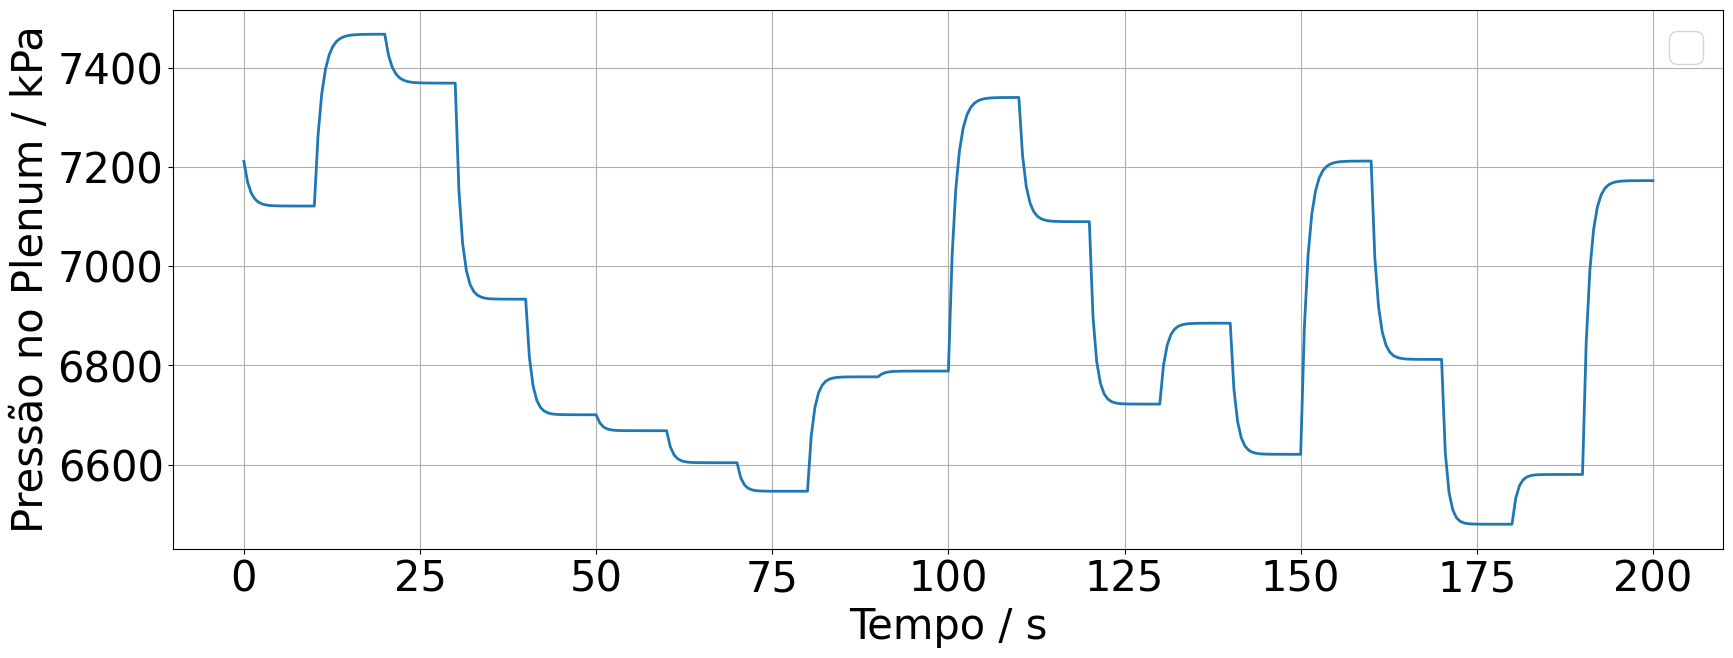

In [57]:

aaaa, PlotP1, PlotN, Plott = Loop(20, stati)



bbb = aaaa
print(PlotP1)
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]

P_p_final = Ploty[:,1]

# Plotar os resultados

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 7))

plt.plot(Plott,Ploty[:, 0],linewidth=2)
plt.xlabel('Tempo / s')
plt.ylabel(r'Vazão Massica $\mathrm{/kg \cdot s^{-1}}$')
plt.legend()
#plt.xlim(0,480)
#plt.ylim(10,14)
plt.xlabel('Tempo / s')
plt.grid(True)
plt.rcParams.update({'font.size': 30})

plt.figure(figsize=(20, 7))

plt.plot(Plott,Ploty[:, 1], linewidth=2)
plt.xlabel('Tempo / s')
#plt.xlim(0,480)
plt.rcParams.update({'font.size': 30})
plt.ylabel('Pressão no Plenum / kPa')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
N_values = np.array(PlotN)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]


# Garantindo que as repetições sejam suficientes
repeated_P1 = np.repeat(P1_values, -(-len(M[:-1]) // len(P1_values)))[:len(M[:-1])]
repeated_N = np.repeat(N_values, -(-len(M[:-1]) // len(N_values)))[:len(M[:-1])]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], repeated_P1, repeated_N))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:] #X_train, X_test = X[120:split_index+split_index//2], X[split_index//2+split_index:]       
y_train, y_test = y[:split_index], y[split_index:] #y_train, y_test = y[120:split_index+split_index//2], y[split_index//2+split_index:]        

In [33]:
print(split_index)
X_train.shape
y_train.shape

199


(199, 2)

In [61]:
X_test_ref = X_test
y_test_ref = y_test
X_train = normalize(X_train,X_train)
X_test =   normalize(X_test,X_test)
y_train = normalize(y_train,y_train)
y_test =   normalize(y_test,y_test)



# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Adiciona dimensão de sequência
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [62]:
print(X_test)

[[-0.17908272 -0.28234337  0.03988089 -0.26867857]
 [-0.17908272 -0.28234337  0.88298986  1.        ]
 [ 1.          0.25869601  0.88298986  1.        ]
 [ 0.88515385  0.57201874  0.88298986  1.        ]
 [ 0.81530663  0.75318257  0.88298986  1.        ]
 [ 0.77367769  0.8578499   0.88298986  1.        ]
 [ 0.74921589  0.91821628  0.88298986  1.        ]
 [ 0.73497517  0.95297454  0.88298986  1.        ]
 [ 0.72671447  0.97300781  0.88298986  1.        ]
 [ 0.72196311  0.98448755  0.88298986  1.        ]
 [ 0.71922424  0.99109069  0.88298986  1.        ]
 [ 0.71764358  0.99489679  0.88298986  1.        ]
 [ 0.71673297  0.99708789  0.88298986  1.        ]
 [ 0.71621274  0.99833915  0.88298986  1.        ]
 [ 0.71591434  0.99905669  0.88298986  1.        ]
 [ 0.71574448  0.99946511  0.88298986  1.        ]
 [ 0.7156445   0.99970546  0.88298986  1.        ]
 [ 0.71558667  0.99984449  0.88298986  1.        ]
 [ 0.71555315  0.99992507  0.88298986  1.        ]
 [ 0.71553342  0.99997251  0.88

In [36]:
print(zero_des_normalize(y_test_ref,y_test_tensor))

[[  11.81402874 6718.32958984]
 [  14.29667377 6970.484375  ]
 [  14.05269337 7115.38671875]
 [  13.90471554 7198.515625  ]
 [  13.81698227 7246.14111328]
 [  13.76575184 7273.38916016]
 [  13.73614597 7288.94824219]
 [  13.71914101 7297.82275391]
 [  13.70941734 7302.87744141]
 [  13.70386505 7305.7578125 ]
 [  13.70070171 7307.39599609]
 [  13.69890213 7308.32714844]
 [  13.69787788 7308.85693359]
 [  13.69729137 7309.16064453]
 [  13.69695854 7309.33300781]
 [  13.69676971 7309.43066406]
 [  13.69666195 7309.48632812]
 [  13.69659996 7309.51855469]
 [  13.69656277 7309.53710938]
 [  13.69654274 7309.54785156]
 [  13.69654274 7309.54785156]
 [  14.13086224 7355.05371094]
 [  14.0839653  7381.69775391]
 [  14.05629158 7397.25097656]
 [  14.04002953 7406.33203125]
 [  14.03051853 7411.62304688]
 [  14.02498531 7414.69433594]
 [  14.02174759 7416.48974609]
 [  14.01986027 7417.53466797]
 [  14.01877022 7418.13867188]
 [  14.01813126 7418.4921875 ]
 [  14.01775742 7418.69921875]
 [  14.0

C:\Users\fabio\AppData\Local\Temp\ipykernel_25380\2731176872.py:62: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



In [ ]:
print(y_test)

[[-0.55767944 -0.90680496]
 [ 0.52653855 -0.41493296]
 [ 0.40423124 -0.14460934]
 [ 0.33329469  0.00285366]
 [ 0.29334773  0.08295433]
 [ 0.27125962  0.12634873]
 [ 0.25921136  0.14975139]
 [ 0.25268521  0.16234907]
 [ 0.24915536  0.16914008]
 [ 0.24724827  0.17280241]
 [ 0.24622695  0.17476181]
 [ 0.24567683  0.17581664]
 [ 0.24537933  0.17638693]
 [ 0.24521795  0.17669623]
 [ 0.24513242  0.17686015]
 [ 0.24508544  0.17695019]
 [ 0.24505985  0.17699922]
 [ 0.24504565  0.17702644]
 [ 0.245038    0.1770411 ]
 [ 0.24503331  0.17705008]
 [ 0.24503331  0.17705008]
 [-1.         -0.44780621]
 [-0.79825774 -0.73249037]
 [-0.71102829 -0.86919589]
 [-0.67035372 -0.93584051]
 [-0.65083614 -0.96848293]
 [-0.64133969 -0.98452204]
 [-0.63670224 -0.99239189]
 [-0.63442542 -0.99626469]
 [-0.63330405 -0.99817429]
 [-0.63276023 -0.9991009 ]
 [-0.6324935  -0.99955549]
 [-0.63236235 -0.99977905]
 [-0.63229716 -0.99989016]
 [-0.6322647  -0.99994551]
 [-0.63224879 -0.99997263]
 [-0.63224071 -0.99998639]
 

In [21]:

# Modelo em PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.Tanh()
        self.fc = nn.Linear(hidden_dim * 2 ,8 )  # 2*hidden_dim por ser bidirecional
        self.fc1 = nn.Linear(8, output_dim)  # 2*hidden_dim por ser bidirecional

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.transpose(0, 1).reshape(-1, h_n.size(2) * 2 )  # Concatenar saídas bidirecionais

        x = self.dropout(h_n)
        x = self.activation(self.fc(x))
        x = self.activation(self.fc1(x))

        return x

In [63]:
# Definir parâmetros do modelo
input_dim = X_train_tensor.shape[2]
output_dim = y_train_tensor.shape[1]

# Treinamento do modelo
n_epochs = 1000
batch_size = 128 # 64   
early_stop_patience = 180

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)




In [ ]:
import optuna 
from optuna.trial import TrialState

def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    hidden_dim = trial.suggest_int("hidden_dim", 10, 90)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad
            ()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    return loss.item()

c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize') #sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize 

[I 2024-12-09 03:11:16,670] A new study created in memory with name: no-name-86ff18f7-49fb-4076-89b4-6ebd464e1925


<bound method Study.optimize of <optuna.study.study.Study object at 0x00000206CD8161D0>>

In [ ]:
study.optimize(objective, n_trials=10)
print(study.best_params
      )

[I 2024-12-09 03:12:33,712] Trial 0 finished with value: 0.001842592260800302 and parameters: {'dropout_rate': 0.26511774341311967, 'hidden_dim': 46, 'learning_rate': 8.076191014209005e-05}. Best is trial 0 with value: 0.001842592260800302.
[I 2024-12-09 03:13:48,342] Trial 1 finished with value: 0.005521135870367289 and parameters: {'dropout_rate': 0.28422683635498763, 'hidden_dim': 56, 'learning_rate': 1.8123763914990712e-05}. Best is trial 0 with value: 0.001842592260800302.
[I 2024-12-09 03:15:03,321] Trial 2 finished with value: 0.699246883392334 and parameters: {'dropout_rate': 0.24859200371554446, 'hidden_dim': 52, 'learning_rate': 0.0008448582946742828}. Best is trial 0 with value: 0.001842592260800302.
[I 2024-12-09 03:16:22,992] Trial 3 finished with value: 0.011465108953416348 and parameters: {'dropout_rate': 0.17749905355769838, 'hidden_dim': 74, 'learning_rate': 1.9699629755985152e-05}. Best is trial 0 with value: 0.001842592260800302.
[I 2024-12-09 03:17:29,712] Trial 4 f

{'dropout_rate': 0.26511774341311967, 'hidden_dim': 46, 'learning_rate': 8.076191014209005e-05}


In [27]:
from plotly.io import show
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_optimization_history(study)
torch.manual_seed(seed)

NameError: name 'optuna' is not defined

In [ ]:
{'dropout_rate': 0.26511774341311967, 'hidden_dim': 46, 'learning_rate': 8.076191014209005e-05}


In [64]:
#<torch._C.Generator at 0x185485dfd30>

3#@best_params = study.best_params
# Definir parâmetros do modelo
hidden_dim =46 #best_params['hidden_dim']  
dropout_rate = 0.265117743413119 #best_params['dropout_rate'] 
learning_rate = 8.076191014209005e-05 #best_params['learning_rate'] 

# Inicializar o modelo, função de perda e otimizador
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#print(best_params)


# Para armazenar as perdas de treino e validação
train_losses = []
val_losses = []
best_loss = float('inf')
patience = 100


for epoch in range(50000):
    model.train()
    batch_train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())
    
    # Perda média do treino na época atual
    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)
    
    model.eval()
    with torch.no_grad():
        batch_val_losses = [criterion(model(X_val), y_val).item() for X_val, y_val in test_loader]
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        #if patience >= early_stop_patience:
            #print("Early stopping")
            #break

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Carregar o melhor modelo salvo
model.load_state_dict(best_model)



Epoch 1/1000, Train Loss: 0.5387675166130066, Val Loss: 0.37832941114902496
Epoch 2/1000, Train Loss: 0.5380165129899979, Val Loss: 0.3777596205472946
Epoch 3/1000, Train Loss: 0.5366967171430588, Val Loss: 0.3771903067827225
Epoch 4/1000, Train Loss: 0.5356771349906921, Val Loss: 0.3766208291053772
Epoch 5/1000, Train Loss: 0.5344396233558655, Val Loss: 0.3760523498058319
Epoch 6/1000, Train Loss: 0.5350224077701569, Val Loss: 0.3754846453666687
Epoch 7/1000, Train Loss: 0.5329689383506775, Val Loss: 0.3749179244041443
Epoch 8/1000, Train Loss: 0.5331723093986511, Val Loss: 0.37435173988342285
Epoch 9/1000, Train Loss: 0.5315377116203308, Val Loss: 0.37378615140914917
Epoch 10/1000, Train Loss: 0.5323407649993896, Val Loss: 0.3732208013534546
Epoch 11/1000, Train Loss: 0.5301317870616913, Val Loss: 0.3726555109024048
Epoch 12/1000, Train Loss: 0.5289694517850876, Val Loss: 0.37208981812000275
Epoch 13/1000, Train Loss: 0.5281714051961899, Val Loss: 0.37152405083179474
Epoch 14/1000, T

<All keys matched successfully>

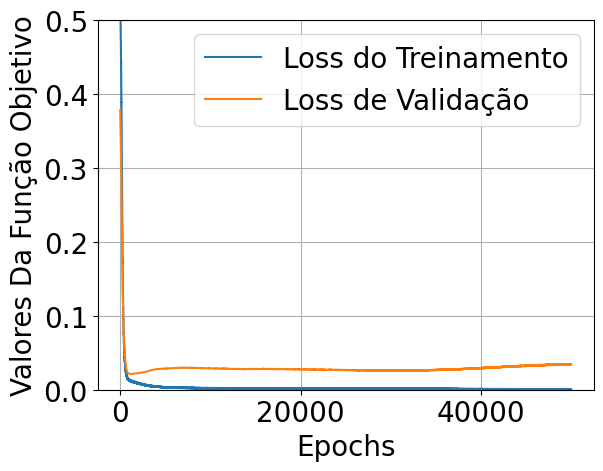

In [65]:
#{'dropout_rate': 0.12203289501741924, 'hidden_dim': 56, 'learning_rate': 4.67573896148755e-05}
plt.plot(train_losses, label='Loss do Treinamento')
plt.plot(val_losses, label='Loss de Validação')
#plt.plot(history.history[.'val_loss'], label='Validation Loss')
plt.legend()
plt.ylim(0,0.5)    
plt.xlabel('Epochs')
plt.ylabel('Valores Da Função Objetivo')

plt.grid()
plt.show()

Tempo de execução: 0.007979393005371094 segundos


C:\Users\fabio\AppData\Local\Temp\ipykernel_25380\2731176872.py:28: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



<Figure size 3000x100 with 0 Axes>

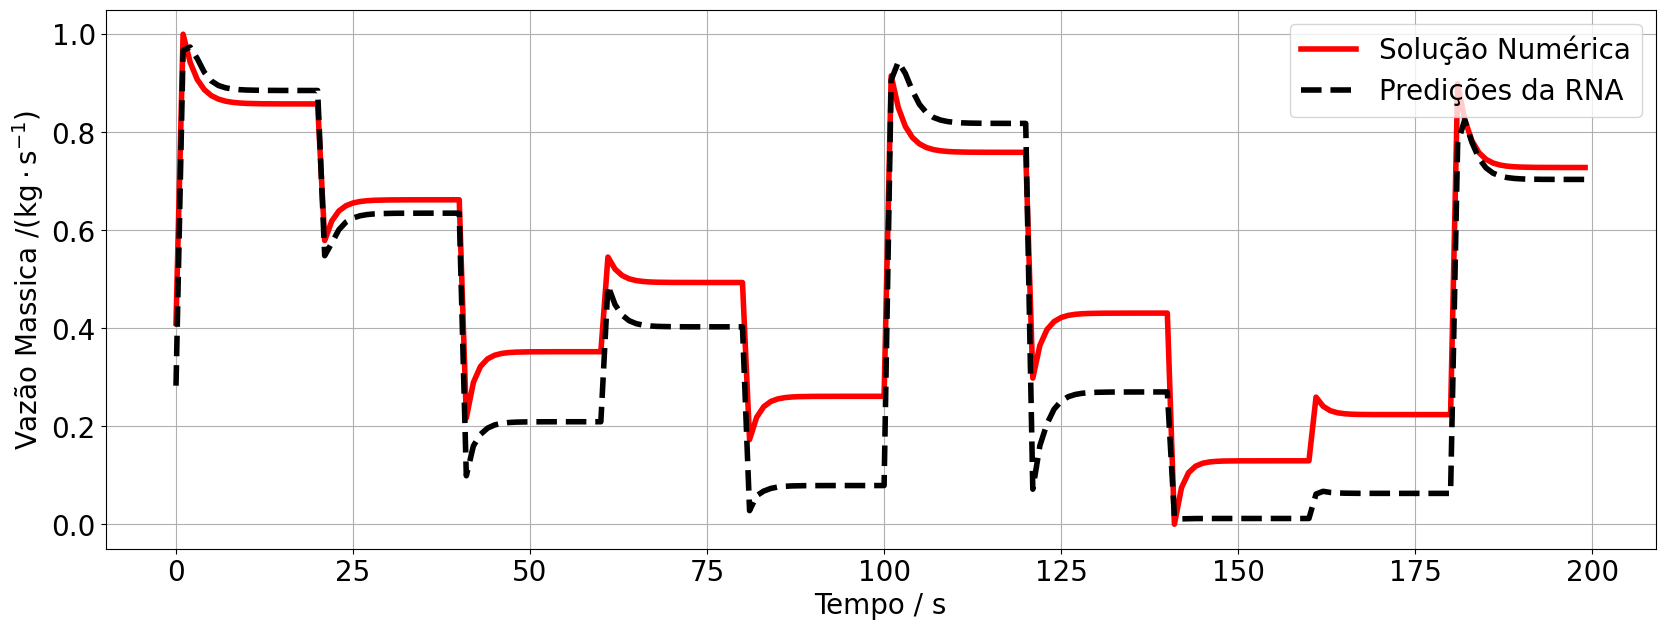

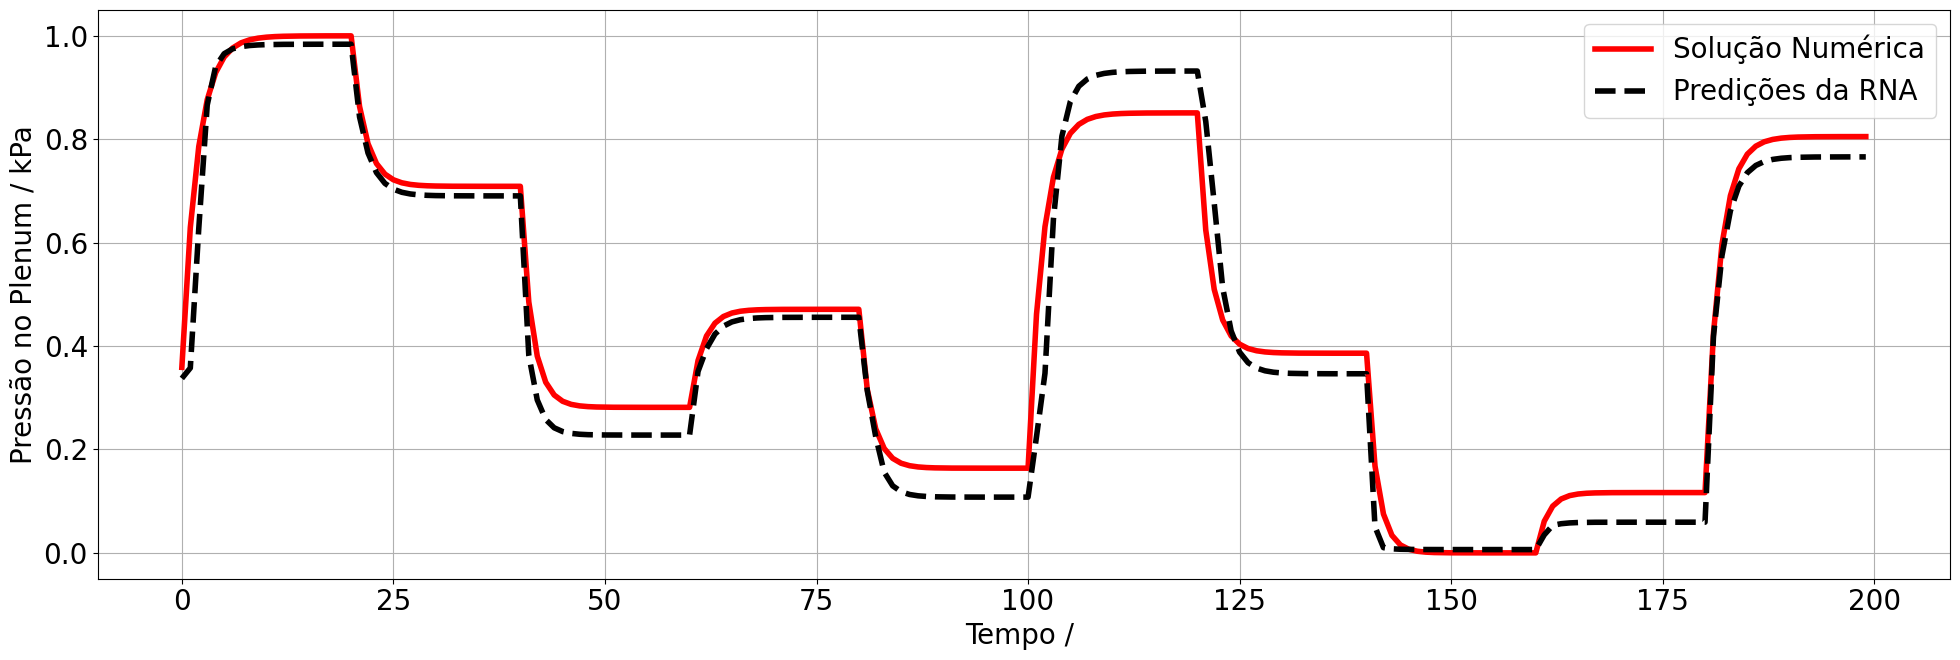

In [68]:
mse = nn.MSELoss()
with torch.no_grad():
    start = time.time()
    y_test_pred = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)


y_test_pred_original = des_normalize(y_test_ref, y_test_pred)
y_test_original = des_normalize(y_test_ref,y_test)

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 7))
plt.plot(y_test_original[:, 0], label="Solução Numérica", color="red", linewidth=4)

plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black", linewidth=4)
plt.xlabel('Tempo / s')
plt.ylabel(r'Vazão Massica $\mathrm{/(kg \cdot s^{-1})}$')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.figure(figsize=(20, 7))
plt.plot(y_test_original[:, 1], label="Solução Numérica", color="red", linewidth=4)
plt.plot(y_test_pred_original[:, 1], "--", label="Predições da RNA", color="black", linewidth=4)
plt.xlabel('Tempo / ')
plt.ylabel('Pressão no Plenum / kPa')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.grid(True)

# Ajustar o layout e mostrar o gráfico

plt.tight_layout()
plt.show()

In [ ]:
#torch.save(model, r"C:\Users\fabio\PycharmProjects\PRH-1\model\modelzzz.pth")

In [ ]:
model_load = torch.load(r"C:\Users\fabio\PycharmProjects\PRH-1\model\modelraony.pth")

C:\Users\fabio\AppData\Local\Temp\ipykernel_19612\2211072651.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_load = torch.load(r"C:\Users\fabio\PycharmProjects\PRH

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\fabio\\PycharmProjects\\PRH-1\\model\\modelraony.pth'

Tempo de execução: 0.003317594528198242 segundos


C:\Users\fabio\AppData\Local\Temp\ipykernel_14352\2731176872.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value


<Figure size 3000x100 with 0 Axes>

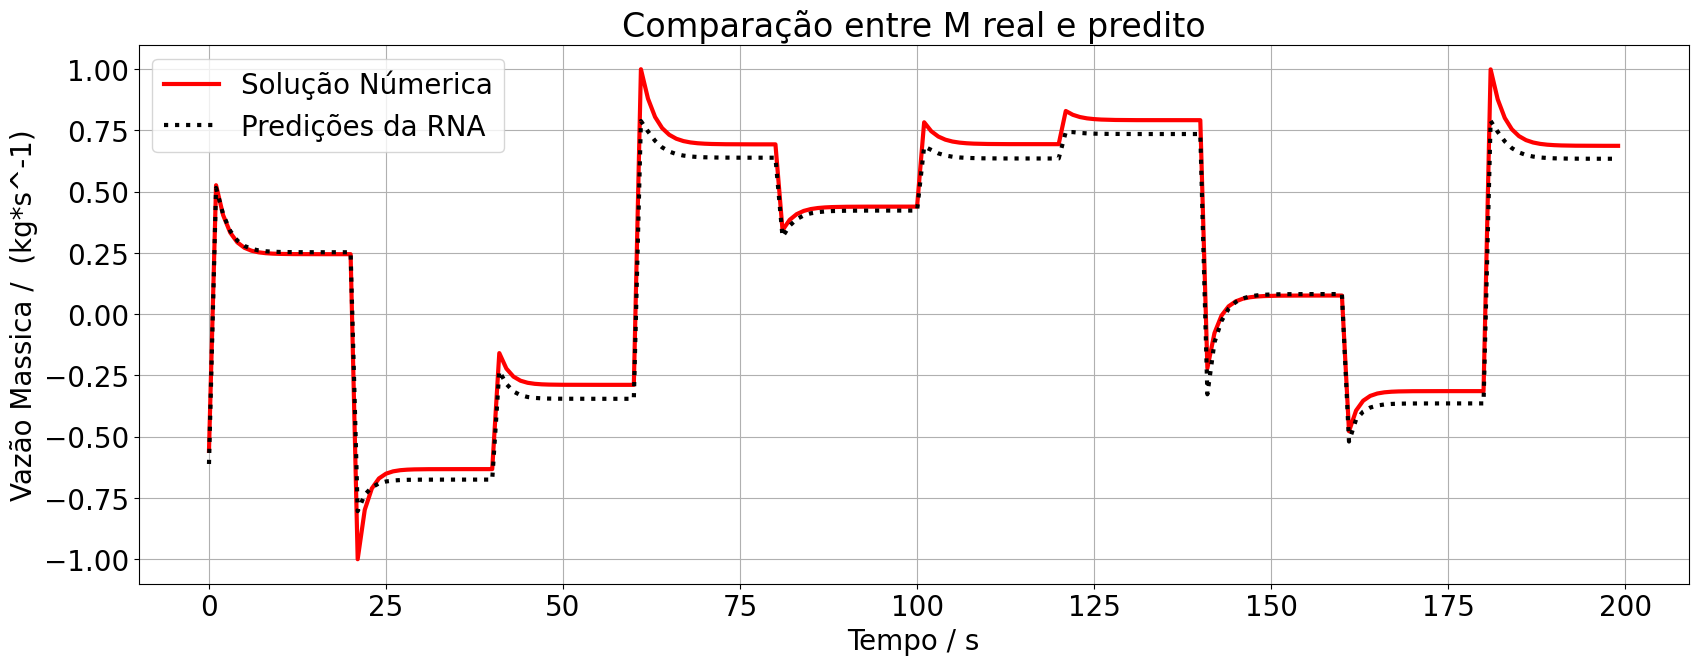

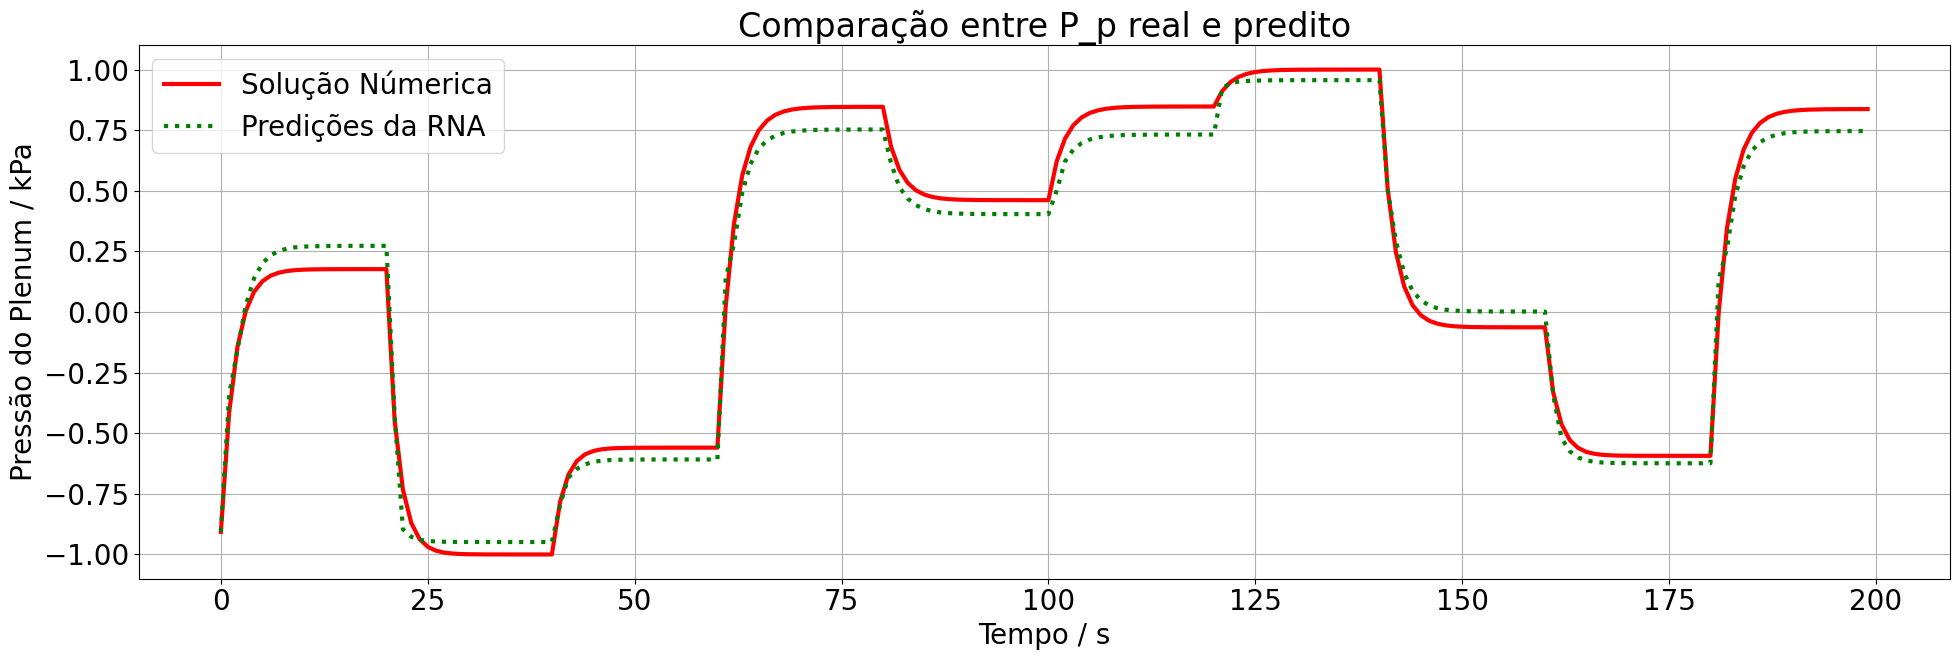

In [ ]:
tempo =np.linspace(0,len(y_test),5760//2)
mse = nn.MSELoss()
start = time.time()
with torch.no_grad():
    start = time.time()
    y_test_pred = model_load(X_test_tensor)

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)

y_test_pred_original = des_normalize(y_test_ref, y_test_pred)
y_test_original = des_normalize(y_test_ref,y_test)

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 7))
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red", linewidth=3)

plt.plot(y_test_pred_original[:, 0], ":", label="Predições da RNA", color="black", linewidth=3)
plt.xlabel('Tempo / s')
plt.ylabel('Vazão Massica /  (kg*s^-1)')
plt.title('Comparação entre M real e predito')

plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.figure(figsize=(20, 7))
plt.plot(y_test_original[:, 1], label="Solução Númerica", color="red", linewidth=3)
plt.plot(y_test_pred_original[:, 1], ":", label="Predições da RNA", color="green", linewidth=3)
plt.xlabel('Tempo / s')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico

plt.tight_layout()
plt.show()

In [ ]:

with torch.no_grad():

    for i in range (10000):
        start = time.time()
        y_test_pred = model(X_test_tensor)
        end = time.time()
        print(f"Tempo de execução: {end - start} segundos")
        test_loss = criterion(y_test_pred, y_test_tensor)
        tempo = end - start
        tempos.append(tempo)
        #print(f"Teste Loss: {test_loss.item()}")


In [ ]:
import seaborn as sns
default_dpi = 96
time_x = np.arange(len(tempos))
tempos = tempos
print(tempos)
def save_or_show(filename: str | None = None):
    if filename is None:
        plt.show()
    else:
        plt.savefig(save_folder + filename)
        plt.clf()
        plt.close()

In [ ]:
def plot_density(values, labels, metric, filename: str | None = None):
    plt.figure(figsize=(10, 4), layout="constrained", dpi=default_dpi)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for i in range(len(values)):
        sns.histplot(
            values[i],
            kde=True,
            label=labels[i],
            stat="density",
            bins=100,
            color=colors[i],
        )

        mean_value = np.mean(values[i])
        plt.axvline(
            mean_value,
            linestyle="--",
            linewidth=1.5,
            color=colors[i],
        )

    plt.xlabel(metric)
    plt.xlim(0.12, max(values[0]))
    plt.ylabel("Densidade de Probabilidade")
    plt.grid()
    plt.legend()

plot_density([tempos], ["Tempo de Execução"], "Tempo de Execução/s")

Tempo de execução: 0.022050142288208008 segundos


C:\Users\fabio\AppData\Local\Temp\ipykernel_14352\2731176872.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value


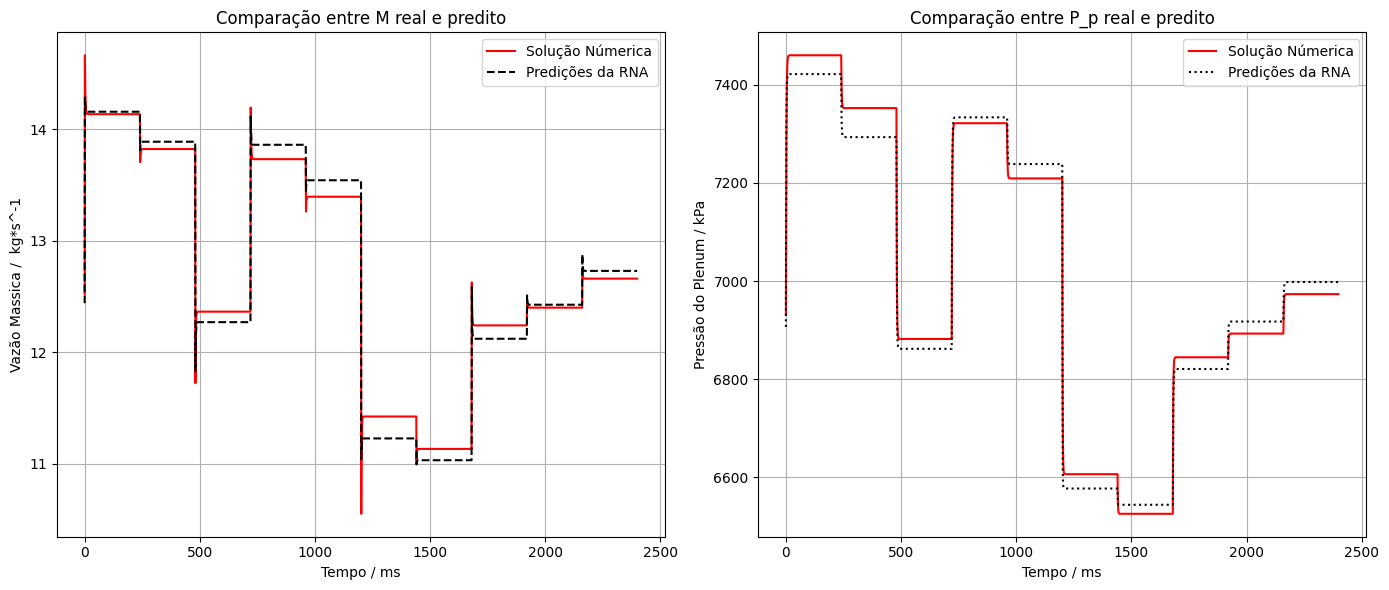

In [ ]:
mse = nn.MSELoss()
with torch.no_grad():
    start = time.time()
    y_test_pred = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)


y_test_pred_original =  des_normalize(y_test_ref,y_test_pred)
y_test_original = des_normalize(y_test_ref,y_test)



plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Vazão Massica /  kg*s^-1')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(y_test_original[:, 1], label="Solução Númerica" ,color="red")
plt.plot(y_test_pred_original[:, 1], ":", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


In [ ]:
#torch.save(model, r"C:\Users\fabio\PycharmProjects\PRH-1\model\model22222222.pth")

In [ ]:
model_load1 = torch.load(r"C:\Users\fabio\PycharmProjects\PRH-1\model\model1111111111.pth")




C:\Users\fabio\AppData\Local\Temp\ipykernel_29652\2437977347.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

